### Wersja poc na samym numpy

In [258]:
import numpy as np, matplotlib.pyplot as plt
from scipy.special import eval_legendre
np.random.seed(0)

In [259]:
deg = 5

def legendre(u, deg):
    """
    Ortonormalne wielomiany Legendre’a przesunięte na [0,1]:
      f_i(u) = sqrt(2i+1) * P_i(2u-1)
    Zwraca tablicę (..., deg+1)
    """
    u = np.asarray(u)
    out = [np.sqrt(2*i+1) * eval_legendre(i, 2*u - 1) for i in range(deg+1)]
    return np.stack(out, axis=-1)


def quantile_norm(x):
    ranks = x.argsort().argsort() + 1
    return ranks / (len(x) + 1)

In [260]:
deg_test = 5
u_grid   = np.linspace(0, 1, 10000)               
F        = legendre(u_grid, deg_test)             
inner = F.T @ F / len(u_grid) 
print(np.round(inner, 4))


[[ 1.0000e+00  0.0000e+00  2.0000e-04 -0.0000e+00  3.0000e-04 -0.0000e+00]
 [ 0.0000e+00  1.0002e+00  0.0000e+00  5.0000e-04  0.0000e+00  6.0000e-04]
 [ 2.0000e-04  0.0000e+00  1.0004e+00  0.0000e+00  7.0000e-04  0.0000e+00]
 [-0.0000e+00  5.0000e-04  0.0000e+00  1.0006e+00 -0.0000e+00  9.0000e-04]
 [ 3.0000e-04  0.0000e+00  7.0000e-04 -0.0000e+00  1.0008e+00  0.0000e+00]
 [-0.0000e+00  6.0000e-04  0.0000e+00  9.0000e-04  0.0000e+00  1.0010e+00]]


jest otronormalna :D

In [261]:
# Syntetyczne dane 2-D: dwa klastry na przekątnych
N = 1000
# te alfa beta dodałem aby testować bardziej złożone sytuacje szybciej
alpha = 0.1
beta = 0.5
x1 = np.concatenate([np.random.randn(N//2)*alpha - beta,
                     np.random.randn(N//2)*alpha + beta])
x2 = np.concatenate([np.random.randn(N//2)*alpha + beta,
                     np.random.randn(N//2)*alpha - beta])
X  = np.column_stack([x1, x2])


In [262]:
# #syntetyczne dane drugi case klasyczne two moons
# from sklearn.datasets import make_moons

# N = 4000
# X, _ = make_moons(n_samples=N, noise=0.01, random_state=0)
# x1, x2 = X[:, 0], X[:, 1]

# X  = np.column_stack([x1, x2])

In [263]:
u1, u2 = quantile_norm(X[:,0]), quantile_norm(X[:,1])
F1, F2 = legendre(u1, deg), legendre(u2, deg)    
a       = (F1.T @ F2) / N                        
f  = legendre(np.array([u2]), deg)[0]
print("F1:", F1.shape, "F2:", F2.shape, "a:", a.shape)

F1: (1000, 6) F2: (1000, 6) a: (6, 6)


In [264]:
def E_u1_given_u2(u2_scalar, eps = 0.05):
    f = legendre(np.array([u2_scalar]), deg)[0]
    num   = sum(a[1,j]*f[j] for j in range(deg+1))
    denom = sum(a[0,j]*f[j] for j in range(deg+1))
    denom = max(denom, eps)
    return num/denom if denom > 1e-5 else np.nan

grid_u2  = np.linspace(0.05, 0.95, 100)
pred_u1  = np.array([E_u1_given_u2(v) for v in grid_u2])


# print("f(u2=0.5) =", legendre(np.array([0.5]), deg)[0])
# print("E_u1|u2=0.5 =", E_u1_given_u2(0.5))


In [265]:
#helper: gęstość ρ(u1,u2) z clampem dodatniości ──
def density(u1_scalar, u2_scalar, eps=0.1):
    f1 = legendre(np.array([u1_scalar]), deg)[0]
    f2 = legendre(np.array([u2_scalar]), deg)[0]
    rho = (a * np.outer(f1, f2)).sum()
    return max(rho, eps)


In [266]:
#funkcja: przybliżona odwrotna CDF -> wracamy do "surowych" jednostek
def inv_cdf(u_val, raw):
    u_val = float(u_val)
    u_val = max(0.0, min(1.0, u_val))       
    return np.quantile(raw, u_val)

pred_raw = np.array([inv_cdf(p, X[:,0]) for p in pred_u1])

pred_raw = np.array([inv_cdf(p, X[:,0]) for p in pred_u1])
grid_raw = np.array([inv_cdf(g, X[:,1]) for g in grid_u2])

# Empiryczne średnie dla porównania
bins        = np.digitize(X[:,1], grid_raw)
true_means  = np.array([X[:,0][bins==i].mean() if (bins==i).sum()>0 else np.nan
                        for i in range(len(grid_raw))])


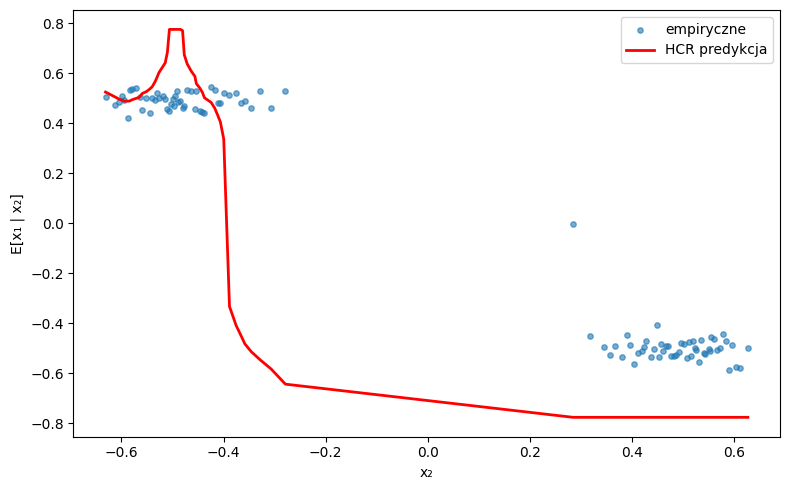

MSE warunkowych średnich ≈ 0.1333


In [267]:
plt.figure(figsize=(8,5))
plt.scatter(grid_raw, true_means, s=15, alpha=0.6, label='empiryczne')
plt.plot(grid_raw, pred_raw, color='red', lw=2, label='HCR predykcja')
plt.xlabel('x₂'); plt.ylabel('E[x₁ | x₂]')
plt.legend(); plt.tight_layout()
plt.show()

mse = np.nanmean((pred_raw - true_means)**2)
print("MSE warunkowych średnich ≈", round(float(mse), 4))


mse takie sobie biorąć pod uwagę prostote tego case`u


### test podejścia robust z paperu Jarka wzór 4

In [268]:

def conditional_density_u1_given_u2(u1_grid, u2_scalar, a, deg, eps=1e-6):
    f2 = legendre(np.array([u2_scalar]), deg)[0]  
    p_joint = np.array([
        (a * np.outer(legendre(np.array([u1]), deg)[0], f2)).sum()
        for u1 in u1_grid
    ])
    p_joint = np.clip(p_joint, eps, None)
    p_joint /= np.trapz(p_joint, u1_grid)
    return p_joint

/tmp/ipykernel_85384/3921937127.py:8: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  p_joint /= np.trapz(p_joint, u1_grid)


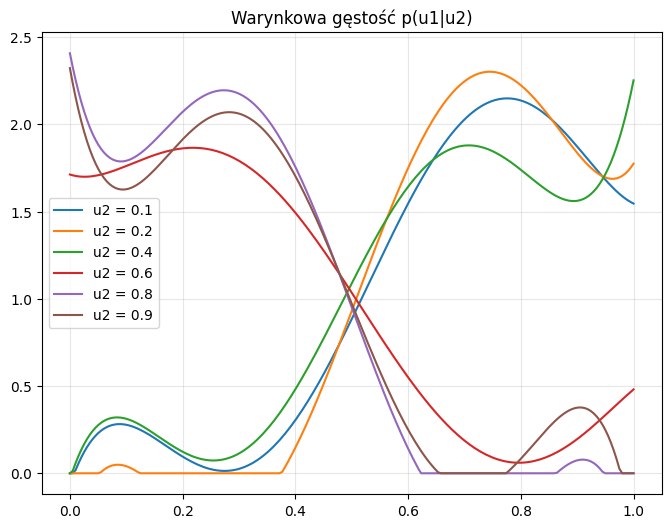

In [269]:
u1_grid_dense = np.linspace(0, 1, 200)

u2_values = [0.1, 0.2, 0.4, 0.6, 0.8, 0.9]  
plt.figure(figsize=(8, 6))

for u2_val in u2_values:
    density_vals = conditional_density_u1_given_u2(u1_grid_dense, u2_val, a, deg)
    plt.plot(u1_grid_dense, density_vals, label=f'u2 = {u2_val:.1f}')

plt.title('Warynkowa gęstość p(u1|u2)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [270]:
def robust_E_u1_given_u2(u2_scalar, a, deg, eps=1e-6):
    u1_grid = np.linspace(0, 1, 200)
    cond_density = conditional_density_u1_given_u2(u1_grid, u2_scalar, a, deg, eps)
    expectation = np.trapz(u1_grid * cond_density, u1_grid)
    return expectation

grid_u2 = np.linspace(0.05, 0.95, 60)
robust_pred_u1 = np.array([robust_E_u1_given_u2(v, a, deg) for v in grid_u2])
robust_pred_u1 = np.clip(robust_pred_u1, 0, 1)

robust_pred_raw = np.array([inv_cdf(p, X[:,0]) for p in robust_pred_u1])
robust_grid_raw = np.array([inv_cdf(g, X[:,1]) for g in grid_u2])

bins = np.digitize(X[:,1], robust_grid_raw)
true_means = np.array([X[:,0][bins==i].mean() if (bins==i).sum()>0 else np.nan
                        for i in range(len(robust_grid_raw))])

/tmp/ipykernel_85384/3921937127.py:8: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  p_joint /= np.trapz(p_joint, u1_grid)
/tmp/ipykernel_85384/3454710147.py:4: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  expectation = np.trapz(u1_grid * cond_density, u1_grid)


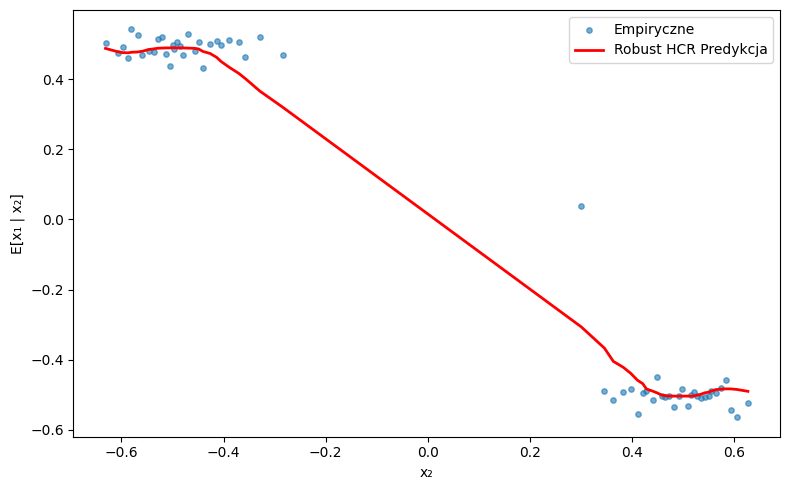

MSE warunkowych średnich ≈ 0.0045


In [271]:
plt.figure(figsize=(8,5))
plt.scatter(robust_grid_raw, true_means, s=15, alpha=0.6, label='Empiryczne')
plt.plot(robust_grid_raw, robust_pred_raw, color='red', lw=2, label='Robust HCR Predykcja')
plt.xlabel('x₂'); plt.ylabel('E[x₁ | x₂]')
plt.legend()
plt.tight_layout()
plt.show()
    
mse_robust = np.nanmean((robust_pred_raw - true_means)**2)
print("MSE warunkowych średnich ≈", round(float(mse_robust), 4))


### test bazy kosinusowej

In [285]:
deg = 4
def cosine_basis(u, deg):
    u = np.array(u)
    output = [np.ones_like(u)]
    for j in range(1, deg+1): # albo deg + 1? nie jestem pewien 
        output.append(np.sqrt(2) * np.cos(np.pi * j * u))
    return np.stack(output, axis=-1) # pamiętaj o axis = -1 inaczej nie jest to ortonormalne 

jest ortonotmalna :D

In [286]:
def E_u1_given_u2(u2_scalar, eps = 0.05):
    f = cosine_basis(np.array([u2_scalar]), deg)[0]
    num   = sum(a[1,j]*f[j] for j in range(deg+1))
    denom = sum(a[0,j]*f[j] for j in range(deg+1))
    denom = max(denom, eps)
    return num/denom if denom > 1e-5 else np.nan

grid_u2  = np.linspace(0, 1, 100)
pred_u1  = np.array([E_u1_given_u2(v) for v in grid_u2])

In [287]:
def inv_cdf(u_val, raw):
    u_val = float(u_val)
    u_val = max(0.0, min(1.0, u_val))       
    return np.quantile(raw, u_val)

pred_raw = np.array([inv_cdf(p, X[:,0]) for p in pred_u1])
grid_raw = np.array([inv_cdf(g, X[:,1]) for g in grid_u2])

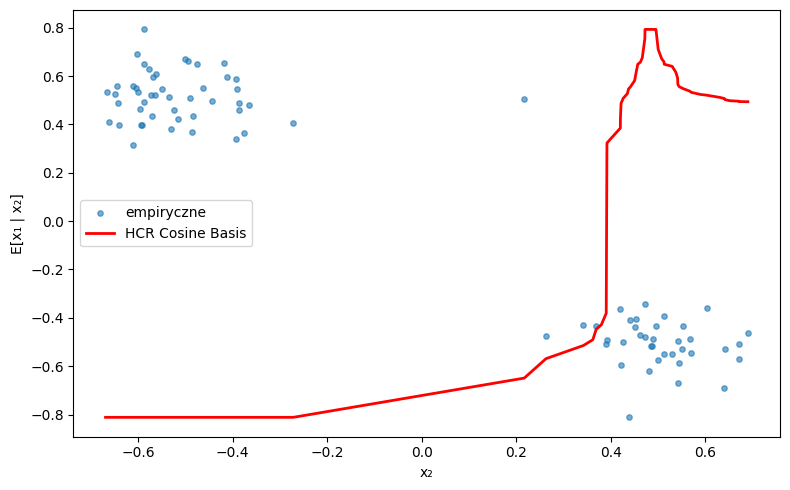

MSE warunkowych średnich ≈ 1.4766


In [288]:
bins = np.digitize(X[:,1], grid_raw)
true_means = np.array([X[:,0][bins==i].mean() if (bins==i).sum()>0 else np.nan
                        for i in range(len(grid_raw))])

plt.figure(figsize=(8,5))
plt.scatter(grid_raw, true_means, s=15, alpha=0.6, label='empiryczne')
plt.plot(grid_raw, pred_raw, color='red', lw=2, label='HCR Cosine Basis')
plt.xlabel('x₂'); plt.ylabel('E[x₁ | x₂]')
plt.legend(); plt.tight_layout()
plt.show()

mse = np.nanmean((pred_raw - true_means)**2)
print("MSE warunkowych średnich ≈", round(float(mse), 4))
